# Analysis of thermistor calibration

# 0. Circuit

```
            VCC
             ┬
             │
             ▒ R_NTC
             │
             ├──────────── --> Goes to microcontroller
             │
             █ R_const
             │
             ┴
            GND 
```

In [1]:
import sys
import math
sys.path.append('../')

# Steinhar Hart equation, coefficients and temperature prediction
from SteinhartHart import SteinHart

# Calculating with static + systematic errors
from formulas import Physical_Unit
from physical_units import *

import matplotlib.pylab as plt
%matplotlib inline

import pandas as pd
import numpy as np 

## 1. Retrieve the data

3 distinct measurements were performed. We will fetch that data and store it in [dataframes](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)

In [2]:
df_cold = pd.read_csv('../data/rev_csv_2018-11-27_10-35.csv')
df_hot = pd.read_csv('../data/rev_csv_2018-11-27_11-02.csv')[:150]
df_avg = pd.read_csv('../data/rev_csv_2018-11-20_11-18.csv')[15:]

df = df_cold
df = df.append(df_hot, ignore_index=True)
df = df.append(df_avg, ignore_index=True)
df.tail(2)

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3
287,58,43918.644068,25.78690,25.78690,-0.321965,0.045522,-0.000132,25.78690,43918.644068,27.6842,41900.552486,29.59512,40764.0
288,59,43918.644068,25.75397,25.75397,-0.314063,0.044407,-0.000129,25.75397,43918.644068,27.6842,41900.552486,29.59512,40764.0


[The  B57621C473J62-ND (NTC)](https://media.digikey.com/pdf/Data%20Sheets/Epcos%20PDFs/B57621C.pdf) its datasheet references to a standardized R/T characteristic.(In our case `R25` = 47kΩ --> **characteristic 2001**).  This characteristic can be found [here](https://www.nikhef.nl/pub/experiments/bfys/lhcb/outerTracker/Electronics/CTRL-Box/NTC-100k/PDF_Standardized.pdf).  The values of that characteristic were stored in [this](../data/B57621C473J62-ND _char.csv) csv file.

In [3]:
R25 = 47e3       # The datasheet specifies that the resistance @ 25 °C should be 47kΩ

# store the characteristic and calculate the resistance of the NTC based on the given coefficients
df_datasheet = pd.read_csv('../data/B57621C473J62-ND _char.csv', names=['T', 'RT_R25'])
df_datasheet['RNTC'] = df_datasheet.apply(lambda r: r.RT_R25 * R25, axis=1)

### 1.1 Analyse the data

Within the succeeding plot we will display the:
* 3 distinct measurments, (cold, avg, hot)
* The characteristic provided by the datasheet

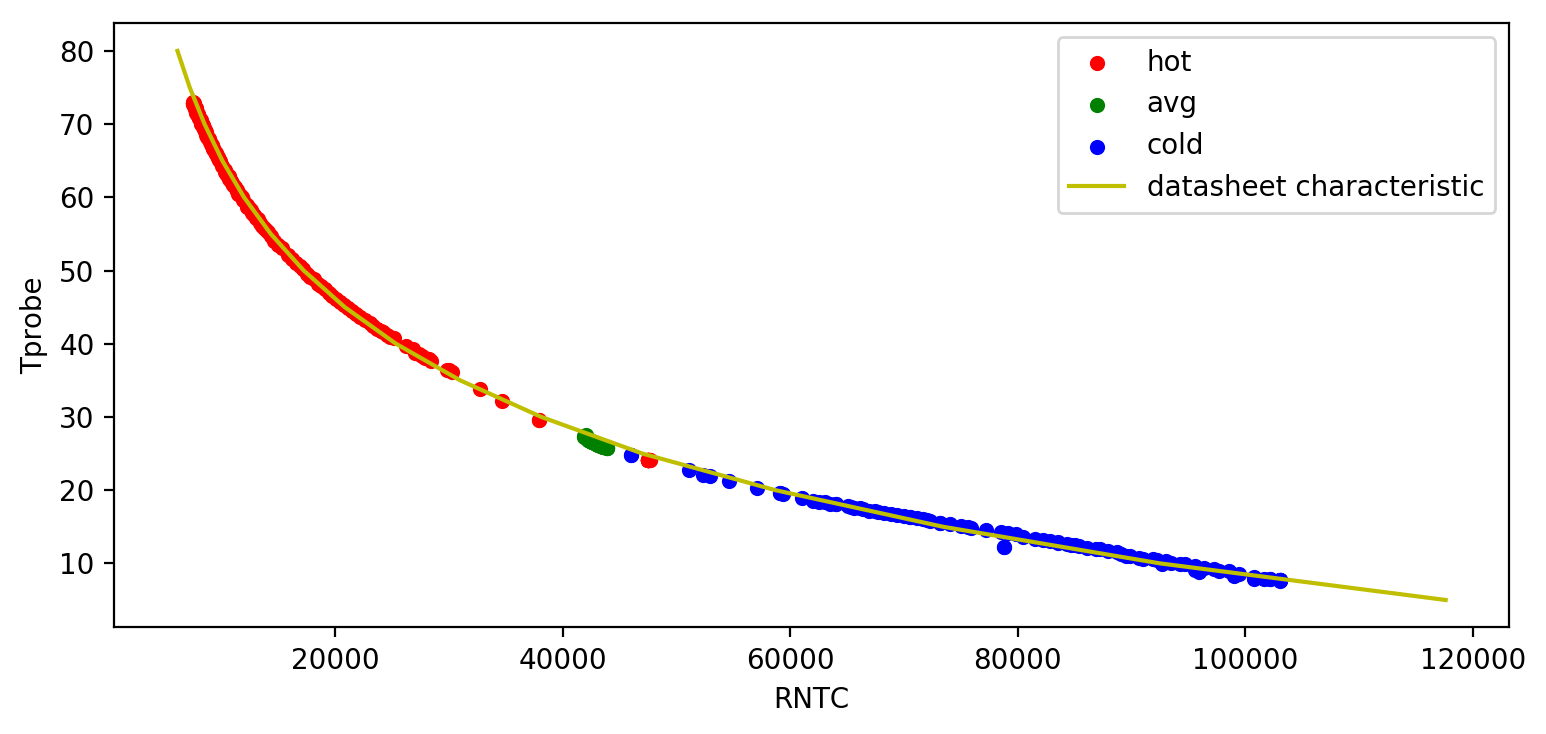

In [4]:
plt.rcParams['figure.dpi'] = 200

# plot the 3 distinct measurements
ax1 = df_hot.plot(kind='scatter', x='RNTC', y='Tprobe', figsize=(9, 4), c='r', label='hot')
df_avg.plot(kind='scatter', x='RNTC', y='Tprobe', c='g', ax=ax1, label='avg')
df_cold.plot(kind='scatter', x='RNTC', y='Tprobe', c='b', ax=ax1, label='cold')

# plot the datasheet characteristic
df_datasheet.plot(kind='line', x='RNTC', y='T', c='y', label='datasheet characteristic', ax=ax1)

## 2. Prediction intervals

In [5]:
##################################
#       Hyperparameters
##################################
adc_resolution = 10 # the number of bits used to sample the adc value
min_temp = 10       # the  minimum temperature we will predict
max_temp = 70       # the maximum temperature we will predict

# The temperature of the coefficients we will use to predict
feed_t1 = 11
feed_t2 = 27        
feed_t3 = 54

fluctuation = 0.3   # Fluctuation: maximum difference in °C with respect to the temperature coefficients.

In [6]:
min_query = " Tprobe < " + str(feed_t1) + " + " + str(fluctuation) + " and Tprobe > " + str(feed_t1) + " - " + str(fluctuation)
avg_query = " Tprobe < " + str(feed_t2) + " + " + str(fluctuation) + " and Tprobe > " + str(feed_t2) + " - " + str(fluctuation)
max_query = " Tprobe < " + str(feed_t3) + " + " + str(fluctuation) + " and Tprobe > " + str(feed_t3) + " - " + str(fluctuation)

min_temp_query = " Tprobe < " + str(min_temp) + " + " + str(fluctuation) + " and Tprobe > " + str(min_temp) + " - " + str(fluctuation)
max_temp_query = " Tprobe < " + str(max_temp) + " + " + str(fluctuation) + " and Tprobe > " + str(max_temp) + " - " + str(fluctuation)

## Define the accuracy


### 1. Serial resistance

Source: [this datasheet (page 111)](https://dam-assets.fluke.com/s3fs-public/45______umeng0400.pdf)

|**Bereik** | **Resolutie** | **Accuraatheid**|
|:--------:|:--------------:|:---------------:|
30 kΩ | 1Ω | 0.05% + 2
300kΩ | 10Ω | 0.05% + 2

In [7]:
# parameters from the fluke 45 datasheet (see table above)
accuracy = 0.05/100
offset = 2
resolution = 10

# measured resistance
serial_resistance = 47550

# calculate the error 
serial_resistance_error = round(serial_resistance * accuracy + offset, -math.floor(math.log10(resolution)))
# Note: we round the error of the resistance at the same magnitude of the resolution (= 10)

r_const = Physical_Unit(RESISTANCE, OHM, serial_resistance, serial_resistance_error)
print("Serial resistance: ", r_const)

Serial resistance:  (47550 ± 30.0) Ω


**Note**:
> To reduce the complexity, the temperature coefficient of the serial resisistance isn't taken into account

### 2. Error on the probe temperature

>[this site](https://www.thorlabs.com/newgrouppage9.cfm?objectgroup_id=5884&pn=TSP01) only specifies the external probes accuracy @ 25°C, which is 0.5 °C. Therefore we will take the internal temperature sensor accuracy, this is 1.0°C. 

In [8]:
TSP01_error = 0.5

example_temp = Physical_Unit(TEMPERATURE, CELCIUS, 25, TSP01_error)
print("probe example temperature: ", example_temp)

probe example temperature:  (25 ± 0.5) °C


### 3. ADC of microcontroller

> Some formulas

In [9]:
ADC_RANGE = 2**adc_resolution - 1

def rntc2adc(rntc):
    return round(serial_resistance * ADC_RANGE / (rntc + serial_resistance), 0)

def rntc2adc_err(rntc):
    return r_const * ADC_RANGE / (rntc + r_const)

In [10]:
# Retrieve some minimum NTC resistances 
RNTC_min, Tprobe_min = df_cold.loc[:, ['RNTC', 'Tprobe']].query(min_temp_query).values[0]
RNTC_max, Tprobe_max = df_hot.loc[:, ['RNTC', 'Tprobe']].query(max_temp_query).values[0]

In [11]:
# Calculate the adc values (with respect to the error on the resistance)
adc_tmin = rntc2adc_err(float(RNTC_min))
adc_tmax = rntc2adc_err(float(RNTC_max))

# print stuff
print("Tmin: {}\tadc: {}".format(round(Tprobe_min, 2), adc_tmin.to_scientific()))
print("Tmax: {}\tadc: {}".format(round(Tprobe_max, 2), adc_tmax.to_scientific()))

Tmin: 9.86	adc: 3.470E+2 ± 3E-1
Tmax: 69.75	adc: 8.70E+2 ± 1E+0


> Now, we will lineairly interpolate to determine the resolution of the ADC

In [12]:
# Define the accuracy of the ADC
Tprobe_max_err = Physical_Unit(TEMPERATURE, CELCIUS, Tprobe_max, TSP01_error)
Tprobe_min_err = Physical_Unit(TEMPERATURE, CELCIUS, Tprobe_min, TSP01_error)

adc_accuracy = (Tprobe_max_err - Tprobe_min_err) / (adc_tmax - adc_tmin)
print(adc_accuracy)

(0.11452038814531548 ± 0.002198650383320185) °C / 


In [13]:
def adc2rntc(adc):
    return serial_resistance * (ADC_RANGE - adc) / adc

def adc2rntc_err(adc):
    return r_const * (-adc + ADC_RANGE) / adc

df['RNTC err'] = df.apply(lambda r: adc2rntc_err(rntc2adc_err(float(r.RNTC))).ae, axis=1)
df.tail(3)

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3,RNTC err
286,57,43918.644068,25.82602,25.82602,-0.331349,0.046846,-0.000136,25.82602,43918.644068,27.6842,41900.552486,29.59512,40764.0,115.417847
287,58,43918.644068,25.78690,25.78690,-0.321965,0.045522,-0.000132,25.78690,43918.644068,27.6842,41900.552486,29.59512,40764.0,115.417847
288,59,43918.644068,25.75397,25.75397,-0.314063,0.044407,-0.000129,25.75397,43918.644068,27.6842,41900.552486,29.59512,40764.0,115.417847


## Query the min max and average temperature to calculate the coefficients

In [14]:
df.query(min_query).head(1)

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3,RNTC err
32,32,90642.1875,10.75949,9.738477,-0.005254,0.001048,-0.000002,7.64621,103049.535604,12.28146,78797.142857,24.78897,45995.480769,174.375


In [15]:
df.query(max_query).head(1)

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3,RNTC err
153,59,14654.15601,54.09549,54.09549,0.00092,0.000207,1.744787e-07,24.16681,47643.052838,29.62064,37939.718805,54.09549,14654.15601,78.491049


In [16]:
df.query(avg_query).head(1)

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3,RNTC err
247,18,41900.552486,27.23694,27.6842,-0.348956,0.049331,-0.000143,25.89944,43918.644068,27.6842,41900.552486,29.59512,40764.0,112.87136


In [17]:
R_NTC1, ERR_NTC1, T1 = df.loc[:, ['RNTC', 'RNTC err', 'Tprobe']].query(min_query).values[0]
R_NTC1 = Physical_Unit(RESISTANCE, OHM, R_NTC1, ERR_NTC1)
T1 = Physical_Unit(TEMPERATURE, CELCIUS, T1, TSP01_error)

R_NTC2, ERR_NTC2, T2 = df.loc[:, ['RNTC', 'RNTC err', 'Tprobe']].query(avg_query).values[0]
R_NTC2 = Physical_Unit(RESISTANCE, OHM, R_NTC2, ERR_NTC2)
T2 = Physical_Unit(TEMPERATURE, CELCIUS, T2, TSP01_error)

R_NTC3, ERR_NTC3, T3 = df.loc[:, ['RNTC', 'RNTC err', 'Tprobe']].query(max_query).values[0]
R_NTC3 = Physical_Unit(RESISTANCE, OHM, R_NTC3, ERR_NTC3)
T3 = Physical_Unit(TEMPERATURE, CELCIUS, T3, TSP01_error)

### Feed the temperature resistance values to the steinhart equation

In [18]:
steinhart = SteinHart()
steinhart.feed(T=T1, R=R_NTC1)
steinhart.feed(T=T2, R=R_NTC2)
steinhart.feed(T=T3, R=R_NTC3)

### Predict the temperature, based on those chosen values

In [19]:
def predT_err(r):
    return steinhart.calculateT(Physical_Unit(RESISTANCE, OHM, r.RNTC, r['RNTC err']))

df['T err'] = df.apply(lambda r: predT_err(r).ae, axis=1)
df['Tcalc 1'] = df.apply(lambda r: predT_err(r).val, axis=1)

df_pred = df # df.query('Tprobe >= ' + str(min_temp) + " and Tprobe  <= " + str(max_temp))
df_pred = df_pred.sort_values('RNTC')
df_pred.head()

,Unnamed: 0,RNTC,Tprobe,Tcalc,A,B,C,T1,R1,T2,R2,T3,R3,RNTC err,T err,Tcalc 1
239,145,7476.753394,72.75217,72.75217,0.001037,0.000190,2.226463e-07,24.16681,47643.052838,29.62064,37939.718805,72.75217,7476.753394,69.434389,3.524669,74.661373
243,149,7476.753394,72.98782,72.98782,0.000984,0.000198,2.010046e-07,24.16681,47643.052838,29.62064,37939.718805,72.98782,7476.753394,69.434389,3.524669,74.661373
242,148,7476.753394,72.86667,72.86667,0.001011,0.000194,2.121271e-07,24.16681,47643.052838,29.62064,37939.718805,72.86667,7476.753394,69.434389,3.524669,74.661373
238,144,7539.071348,72.69208,72.69208,0.000996,0.000196,2.058027e-07,24.16681,47643.052838,29.62064,37939.718805,72.69208,7539.071348,69.513024,3.498006,74.388896
240,146,7539.071348,72.85031,72.85031,0.000961,0.000201,1.911263e-07,24.16681,47643.052838,29.62064,37939.718805,72.85031,7539.071348,69.513024,3.498006,74.388896


## Results

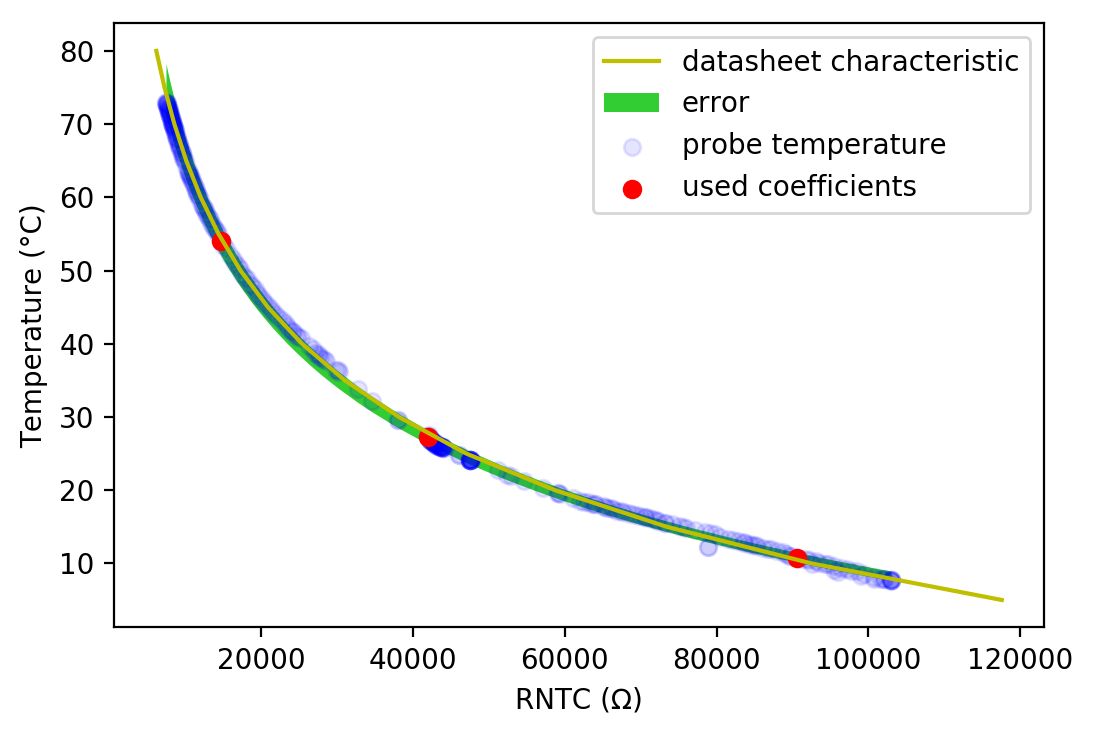

In [20]:
plt.rcParams['figure.dpi'] = 200

lower_bound = df_pred['Tcalc 1'].values - df_pred['T err'].values
upper_bound = df_pred['Tcalc 1'].values + df_pred['T err'].values

plt.fill_between(x=df_pred['RNTC'].values, y1=lower_bound, y2=upper_bound, facecolor='limegreen', interpolate=True, label='error')

plt.scatter(x=df_pred['RNTC'].values, y=df_pred['Tprobe'].values, c='b', alpha=.1, label='probe temperature')
plt.scatter(x=[R_NTC1.val, R_NTC2.val, R_NTC3.val], y = [T1.val, T2.val, T3.val], c='r', label='used coefficients')
plt.plot(df_datasheet['RNTC'].values, df_datasheet['T'].values, c='y', label='datasheet characteristic')

plt.xlabel("RNTC (Ω)")
plt.ylabel("Temperature (°C)")
plt.legend()

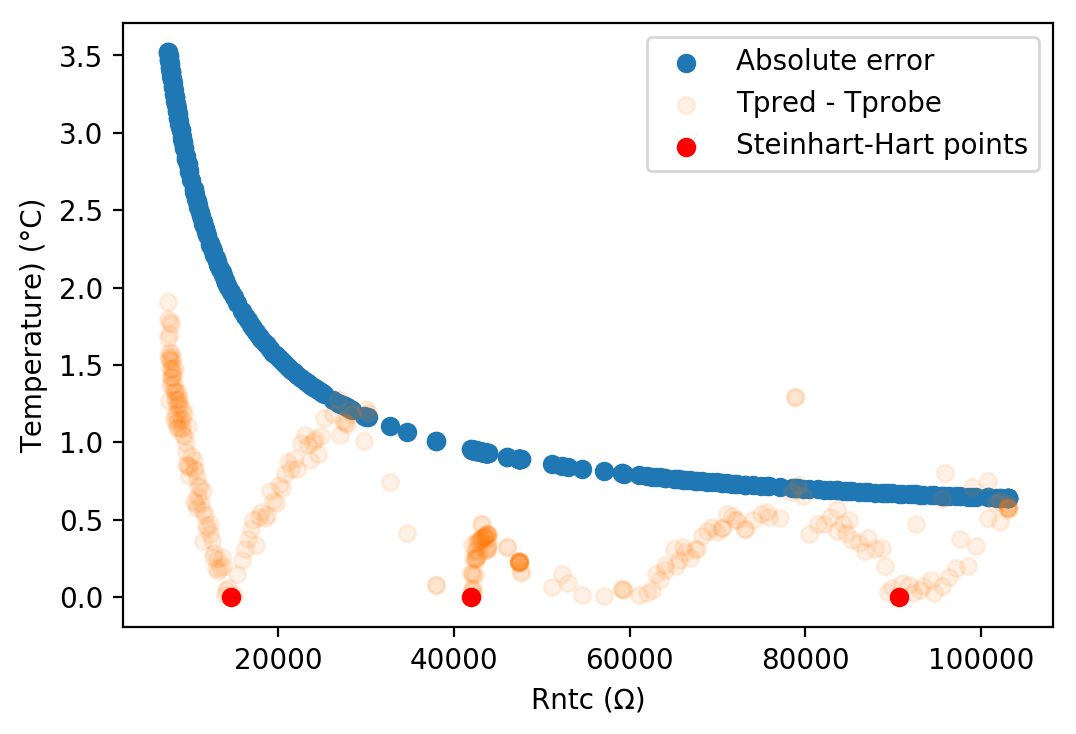

In [21]:
plt.scatter(x=df_pred['RNTC'], y=df_pred['T err'], label='Absolute error')
plt.scatter(x=df_pred['RNTC'], y=np.abs(df_pred['Tcalc 1'] - df_pred['Tprobe']), label='Tpred - Tprobe' , alpha=0.1)
plt.scatter(x=[R_NTC1.val, R_NTC2.val, R_NTC3.val], y = [0, 0, 0], c='r', label='Steinhart-Hart points')

plt.xlabel("Rntc (Ω)")
plt.ylabel("Temperature) (°C)")
plt.legend()

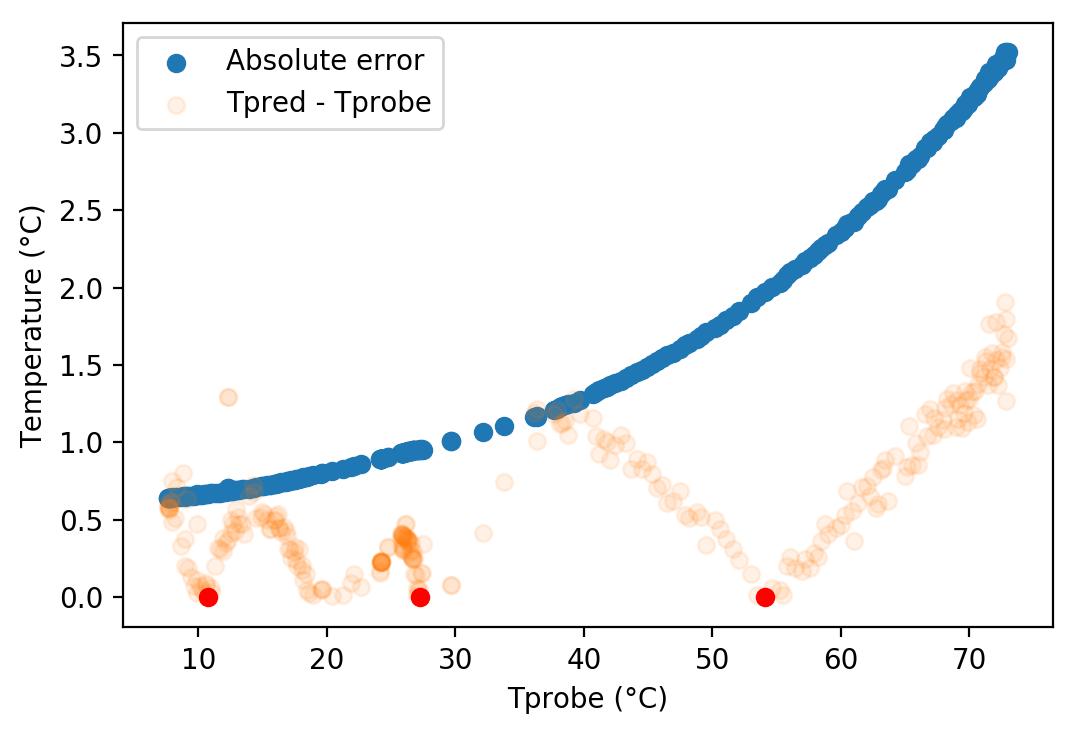

In [22]:
plt.scatter(x=df_pred['Tprobe'], y=df_pred['T err'], label='Absolute error')
plt.scatter(x=df_pred['Tprobe'], y=np.abs(df_pred['Tcalc 1'] - df_pred['Tprobe']), label='Tpred - Tprobe' , alpha=0.1)
plt.scatter(x=[T1.val, T2.val, T3.val], y = [0, 0, 0], c='r')

plt.xlabel("Tprobe (°C)")
plt.ylabel("Temperature (°C)")
plt.legend()

---